In [5]:
!pip install highspy

from pyomo.opt import SolverFactory
print(SolverFactory("highs").available())


   ---------------------------------------- 0.0/2.0 MB ? eta -:--:--
   ------------------------------------ --- 1.8/2.0 MB 10.1 MB/s eta 0:00:01
   ---------------------------------------- 2.0/2.0 MB 9.2 MB/s eta 0:00:00
True


In [1]:
#Check data for Optimiser, Run this first!
import pandas as pd
import numpy as np

# === CONFIGURATION ===
data_path = r"C:\Users\spice\Dropbox\Documents\Imperial 2024.2025\MECH70038 - Research Projects\_My Thesis\Data\Battery Emissions Optimisation Sheet.csv"

# === LOAD DATA ===
df = pd.read_csv(data_path)
df['SettlementPeriod'] = df['SettlementPeriod'].fillna(0).astype(int)
df['datetime'] = pd.to_datetime(df['SettlementDate'], dayfirst=True, errors='coerce') + pd.to_timedelta((df['SettlementPeriod'] - 1) * 30, unit='m')
df = df.sort_values('datetime').reset_index(drop=True)

# === EXTRACT SERIES ===
charge = -df['BatteryChargeMWh'].fillna(0).to_numpy()
discharge = df['BatteryDischargeMWh'].fillna(0).to_numpy()
price = df['EmissionFactor'].fillna(0).to_numpy()

# === CHECKS ===
print("--- DATA VALIDATION REPORT ---")

# Check for NaN or Inf
def check_array(name, arr):
    if np.isnan(arr).any():
        print(f"[!] {name} contains NaN values at indices: {np.where(np.isnan(arr))[0]}")
    else:
        print(f"[OK] {name} contains no NaN values.")

    if np.isinf(arr).any():
        print(f"[!] {name} contains Inf values at indices: {np.where(np.isinf(arr))[0]}")
    else:
        print(f"[OK] {name} contains no Inf values.")

    if (arr == 0).all():
        print(f"[!] {name} is all zeros — check for missing or bad data.")

check_array("Charge", charge)
check_array("Discharge", discharge)
check_array("Price", price)

# Check efficiency
total_charge = charge.sum()
total_discharge = discharge.sum()

if total_charge <= 0:
    print("[!] Total charge is zero or negative — optimisation will fail.")
else:
    efficiency = total_discharge / total_charge
    print(f"[OK] Efficiency = {efficiency:.3f}")
    if not (0.5 <= efficiency <= 1.05):
        print("[!] Efficiency is outside expected bounds (0.5–1.05) — may indicate data issues.")

# Check datetime conversion
if df['datetime'].isna().any():
    print(f"[!] Some datetime values could not be parsed. Affected rows: {df[df['datetime'].isna()].index.tolist()}")
else:
    print("[OK] All datetime values parsed correctly.")

print("--- END OF REPORT ---")


--- DATA VALIDATION REPORT ---
[OK] Charge contains no NaN values.
[OK] Charge contains no Inf values.
[OK] Discharge contains no NaN values.
[OK] Discharge contains no Inf values.
[OK] Price contains no NaN values.
[OK] Price contains no Inf values.
[OK] Efficiency = 0.844
[OK] All datetime values parsed correctly.
--- END OF REPORT ---


In [ ]:
# LP version – performance-optimised with precomputed shift mappings
# Now with: (a) soc_start baseline offset, (b) HiGHS-first solver with CBC fallback
#This took 9 and a half minutes to run

import pandas as pd
import numpy as np
from pyomo.environ import *
from pyomo.opt import SolverFactory
from collections import defaultdict

# === CONFIGURATION ===
data_path = r"C:\Users\spice\Dropbox\Documents\Imperial 2024.2025\MECH70038 - Research Projects\_My Thesis\Data\Battery Emissions Optimisation Sheet.csv"
mode = "independent"  # Options: "together" or "independent"
shift_window = 24     # Number of half-hour periods before/after allowed to shift

# === LOAD & PREPROCESS DATA ===
df = pd.read_csv(data_path)
df['SettlementDate'] = df['SettlementDate'].astype(str)
df['SettlementPeriod'] = df['SettlementPeriod'].fillna(0).astype(int)
df['datetime'] = pd.to_datetime(df['SettlementDate'], dayfirst=True, errors='coerce') + \
                 pd.to_timedelta((df['SettlementPeriod'] - 1) * 30, unit='m')
df = df.dropna(subset=['datetime']).sort_values('datetime').reset_index(drop=True)

T = len(df)
charge = -df['BatteryChargeMWh'].fillna(0).to_numpy()   # ensure positive values
discharge = df['BatteryDischargeMWh'].fillna(0).to_numpy()
price = df['EmissionFactor'].fillna(0).to_numpy()

# === Efficiency and SoC bounds (max range over rolling 2-day window) ===
total_charge = charge.sum()
total_discharge = discharge.sum()
efficiency = total_discharge / total_charge if total_charge > 0 else 1.0

# SoC trace from original data (using derived round-trip efficiency)
soc_trace = efficiency * np.cumsum(charge) - np.cumsum(discharge)

# Windowing params: 48 periods per day in GB, so 2 days = 96
periods_per_day = 48
window_days = 2
window_periods = periods_per_day * window_days  # = 96

# Compute maximum SoC range over all rolling 2-day windows
if len(soc_trace) >= window_periods:
    soc_series = pd.Series(soc_trace)
    rolling_max = soc_series.rolling(window=window_periods, min_periods=window_periods).max()
    rolling_min = soc_series.rolling(window=window_periods, min_periods=window_periods).min()
    rolling_range = rolling_max - rolling_min
    max_change = float(rolling_range.max())
else:
    # Not enough data for a full 2-day window; use the series-wide range
    max_change = float(np.max(soc_trace) - np.min(soc_trace))

# Symmetric SoC bounds so (soc_max - soc_min) = max_change
soc_half_range = max_change / 2.0
soc_min = -soc_half_range
soc_max =  soc_half_range

# Per-slot power limits from observed data
max_charge_power = float(charge.max())
max_discharge_power = float(discharge.max())

# === BUILD MODEL ===
model = ConcreteModel()

# Index sets
model.T = RangeSet(0, T - 1)
model.S = RangeSet(0, T - 1)

# Shiftable pairs and precomputed fast lookup
valid_shifts = {(t, s) for t in range(T) for s in range(T) if abs(s - t) <= shift_window}
model.shift_pairs = Set(dimen=2, initialize=valid_shifts)

shift_targets = defaultdict(list)  # valid s values per t
shift_sources = defaultdict(list)  # valid t values per s
for t, s in valid_shifts:
    shift_targets[t].append(s)
    shift_sources[s].append(t)

# Variables (LP relaxation)
model.x_charge = Var(model.shift_pairs, domain=UnitInterval)
model.x_discharge = Var(model.shift_pairs, domain=UnitInterval)

# Shifted energy expressions
def shifted_energy_rule(m, s):
    return sum(charge[t] * m.x_charge[t, s] for t in shift_sources[s])
model.charge_shifted = Expression(model.S, rule=shifted_energy_rule)

def shifted_discharge_rule(m, s):
    return sum(discharge[t] * m.x_discharge[t, s] for t in shift_sources[s])
model.discharge_shifted = Expression(model.S, rule=shifted_discharge_rule)

# Objective: maximise price-weighted net export
model.obj = Objective(
    expr=sum(price[s] * (model.discharge_shifted[s] - model.charge_shifted[s]) for s in model.S),
    sense=maximize
)

# Assignment constraints
if mode == "independent":
    model.charge_assignment = ConstraintList()
    model.discharge_assignment = ConstraintList()
    for t in range(T):
        model.charge_assignment.add(sum(model.x_charge[t, s] for s in shift_targets[t]) == 1.0)
        model.discharge_assignment.add(sum(model.x_discharge[t, s] for s in shift_targets[t]) == 1.0)
elif mode == "together":
    model.shared_assignment = ConstraintList()
    for t in range(T):
        for s in shift_targets[t]:
            model.shared_assignment.add(model.x_charge[t, s] == model.x_discharge[t, s])
        model.shared_assignment.add(sum(model.x_charge[t, s] for s in shift_targets[t]) == 1.0)
else:
    raise ValueError("mode must be 'independent' or 'together'.")

# Power limits per half-hour
model.charge_power_limit = ConstraintList()
model.discharge_power_limit = ConstraintList()
for s in range(T):
    model.charge_power_limit.add(model.charge_shifted[s] <= max_charge_power)
    model.discharge_power_limit.add(model.discharge_shifted[s] <= max_discharge_power)

# === SoC tracking with free baseline offset ===
model.soc_start = Var(domain=Reals)     # <-- lets optimizer choose baseline (decouples capacity from baseline)
model.SoC = Var(model.S, domain=Reals)
model.soc_bounds = ConstraintList()
model.soc_def = ConstraintList()
for s in range(T):
    flow = efficiency * model.charge_shifted[s] - model.discharge_shifted[s]
    if s == 0:
        model.soc_def.add(model.SoC[s] == model.soc_start + flow)
    else:
        model.soc_def.add(model.SoC[s] == model.SoC[s - 1] + flow)
    model.soc_bounds.add(model.SoC[s] >= soc_min)
    model.soc_bounds.add(model.SoC[s] <= soc_max)

# === SOLVE (prefer HiGHS IPM, fallback to simplex, then CBC) ===
solver_used = None
results = None
last_err = None
for name in ("appsi_highs", "highs", "cbc"):
    try:
        opt = SolverFactory(name)
        if not opt.available():
            continue
        if name in ("appsi_highs", "highs"):
            # Prefer interior-point on large LPs; allow all threads; keep presolve on
            try:
                opt.options.update({
                    "solver": "ipm",   # "ipm" | "simplex" | "choose"
                    "presolve": "on",
                    "threads": 0,      # 0 = all cores
                    "parallel": "on",
                })
            except Exception:
                # Some plugin wrappers don’t accept options via dict; ignore
                pass
        solver_used = name
        results = opt.solve(model, tee=True)
        break
    except Exception as e:
        last_err = e
        continue

if results is None:
    raise RuntimeError(f"No LP solver available (tried appsi_highs, highs, cbc). Last error: {last_err}")

print("Solver used:", solver_used)
print("Status:", results.solver.status)
print("Termination:", results.solver.termination_condition)

if (results.solver.status != SolverStatus.ok) or (results.solver.termination_condition not in (TerminationCondition.optimal, TerminationCondition.locallyOptimal)):
    raise RuntimeError(f"Solver did not find optimal solution. Status={results.solver.status}, Termination={results.solver.termination_condition}")

# === POSTPROCESS ===
new_charge = np.zeros(T)
new_discharge = np.zeros(T)
for s in range(T):
    new_charge[s] = value(model.charge_shifted[s])
    new_discharge[s] = value(model.discharge_shifted[s])

df['OptimisedChargeMWh'] = -new_charge
df['OptimisedDischargeMWh'] = new_discharge

df.to_csv(data_path.replace('.csv', '_optimised_LP.csv'), index=False)
print("LP Relaxation Optimisation complete. Output saved.")


Running HiGHS 1.11.0 (git hash: 364c83a): Copyright (c) 2025 HiGHS under MIT licence terms
RUN!
LP   has 122640 rows; 1733281 cols; 5211936 nonzeros
Coefficient ranges:
  Matrix [1e-03, 9e+02]
  Cost   [3e-02, 2e+05]
  Bound  [1e+00, 1e+00]
  RHS    [1e+00, 2e+03]
Presolving model
87599 rows, 1730624 cols, 5174190 nonzeros  1s
Dependent equations search running on 52503 equations with time limit of 1000.00s
Dependent equations search removed 0 rows and 0 nonzeros in 0.16s (limit = 1000.00s)
87543 rows, 1730568 cols, 5174134 nonzeros  3s
Presolve : Reductions: rows 87543(-35097); columns 1730568(-2713); elements 5174134(-37802)
Solving the presolved LP
IPX model has 87543 rows, 1730568 columns and 5174134 nonzeros
Input
    Number of variables:                                1730568
    Number of free variables:                           0
    Number of constraints:                              87543
    Number of equality constraints:                     52503
    Number of matrix entr

In [14]:
print(soc_min)
print(soc_max)
print(max_charge_power)
print(max_discharge_power)

-1868.7834286098368
1868.7834286098368
873.249
832.295


Final Actual Cumulative tCO₂:     -7,852.95
Final Optimised Cumulative tCO₂: -80,488.86
Further Emission Saving Potential tCO₂:          72,635.91


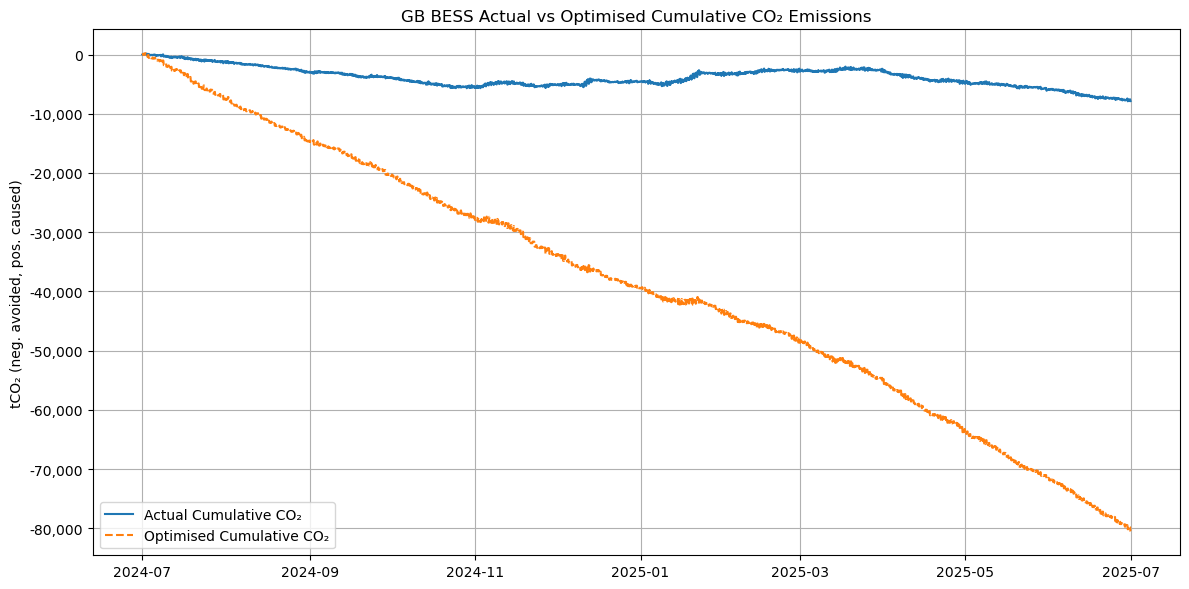

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

# === Load CSV ===
file_path = r"C:\Users\spice\Dropbox\Documents\Imperial 2024.2025\MECH70038 - Research Projects\_My Thesis\Data\Battery Emissions Optimisation Sheet_optimised_LP (actual data).csv"
df = pd.read_csv(file_path)

# === Parse datetime if needed ===
if not pd.api.types.is_datetime64_any_dtype(df['datetime']):
    df['datetime'] = pd.to_datetime(df['datetime'], dayfirst=True)

# === Calculate net discharge (export to grid) ===
df['NetDischarge_actual'] = df['BatteryDischargeMWh'] + df['BatteryChargeMWh']
df['NetDischarge_optimised'] = df['OptimisedDischargeMWh'] + df['OptimisedChargeMWh']

# === CO2 emissions (export × emissions intensity) ===
df['CO2_actual'] = df['NetDischarge_actual'] * df['EmissionFactor']/1000
df['CO2_optimised'] = df['NetDischarge_optimised'] * df['EmissionFactor']/1000

# === Cumulative emissions - flip signs to treat negative as avoided ===
df['CumCO2_actual'] = -df['CO2_actual'].cumsum()
df['CumCO2_optimised'] = -df['CO2_optimised'].cumsum()

# === Print final cumulative values ===
final_actual = df['CumCO2_actual'].iloc[-1]
final_optimised = df['CumCO2_optimised'].iloc[-1]
emissions_saving_potential = final_actual - final_optimised

print(f"Final Actual Cumulative tCO₂:     {final_actual:,.2f}")
print(f"Final Optimised Cumulative tCO₂: {final_optimised:,.2f}")
print(f"Further Emission Saving Potential tCO₂:          {emissions_saving_potential:,.2f}")

# === Plot ===
plt.figure(figsize=(12, 6))
plt.plot(df['datetime'], df['CumCO2_actual'], label='Actual Cumulative CO₂')
plt.plot(df['datetime'], df['CumCO2_optimised'], label='Optimised Cumulative CO₂', linestyle='--')


plt.ylabel('tCO\u2082 (neg. avoided, pos. caused)')
plt.title('GB BESS Actual vs Optimised Cumulative CO₂ Emissions')
plt.legend()
plt.grid(True)
# Format y-axis as full integers with commas
ax = plt.gca()
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f'{int(x):,}'))
plt.tight_layout()
plt.show()


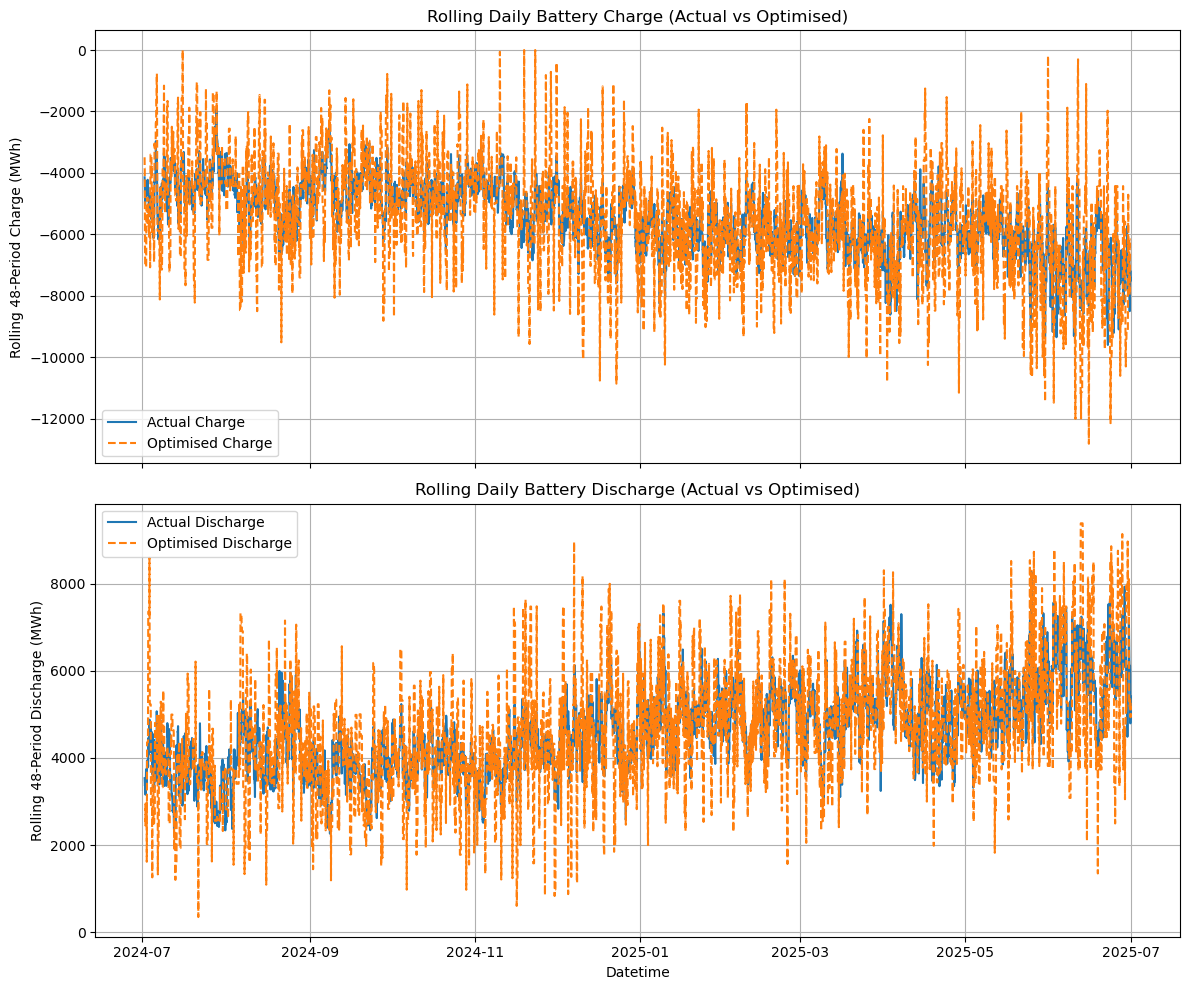

In [10]:
import pandas as pd
import matplotlib.pyplot as plt

# === Load data ===
file_path = r"C:\Users\spice\Dropbox\Documents\Imperial 2024.2025\MECH70038 - Research Projects\_My Thesis\Data\Battery Emissions Optimisation Sheet_optimised_LP.csv"
df = pd.read_csv(file_path)

# === Parse datetime if needed ===
if not pd.api.types.is_datetime64_any_dtype(df['datetime']):
    df['datetime'] = pd.to_datetime(df['datetime'], dayfirst=True)

# === Rolling sums of charge and discharge ===
df['RollingCharge_actual'] = df['BatteryChargeMWh'].rolling(window=48, min_periods=48).sum()
df['RollingCharge_optimised'] = df['OptimisedChargeMWh'].rolling(window=48, min_periods=48).sum()

df['RollingDischarge_actual'] = df['BatteryDischargeMWh'].rolling(window=48, min_periods=48).sum()
df['RollingDischarge_optimised'] = df['OptimisedDischargeMWh'].rolling(window=48, min_periods=48).sum()

# === Plot ===
fig, axs = plt.subplots(2, 1, figsize=(12, 10), sharex=True)

# --- Subplot 1: Charge ---
axs[0].plot(df['datetime'], df['RollingCharge_actual'], label='Actual Charge')
axs[0].plot(df['datetime'], df['RollingCharge_optimised'], label='Optimised Charge', linestyle='--')
axs[0].set_ylabel('Rolling 48-Period Charge (MWh)')
axs[0].set_title('Rolling Daily Battery Charge (Actual vs Optimised)')
axs[0].legend()
axs[0].grid(True)

# --- Subplot 2: Discharge ---
axs[1].plot(df['datetime'], df['RollingDischarge_actual'], label='Actual Discharge')
axs[1].plot(df['datetime'], df['RollingDischarge_optimised'], label='Optimised Discharge', linestyle='--')
axs[1].set_ylabel('Rolling 48-Period Discharge (MWh)')
axs[1].set_title('Rolling Daily Battery Discharge (Actual vs Optimised)')
axs[1].legend()
axs[1].grid(True)

plt.xlabel('Datetime')
plt.tight_layout()
plt.show()


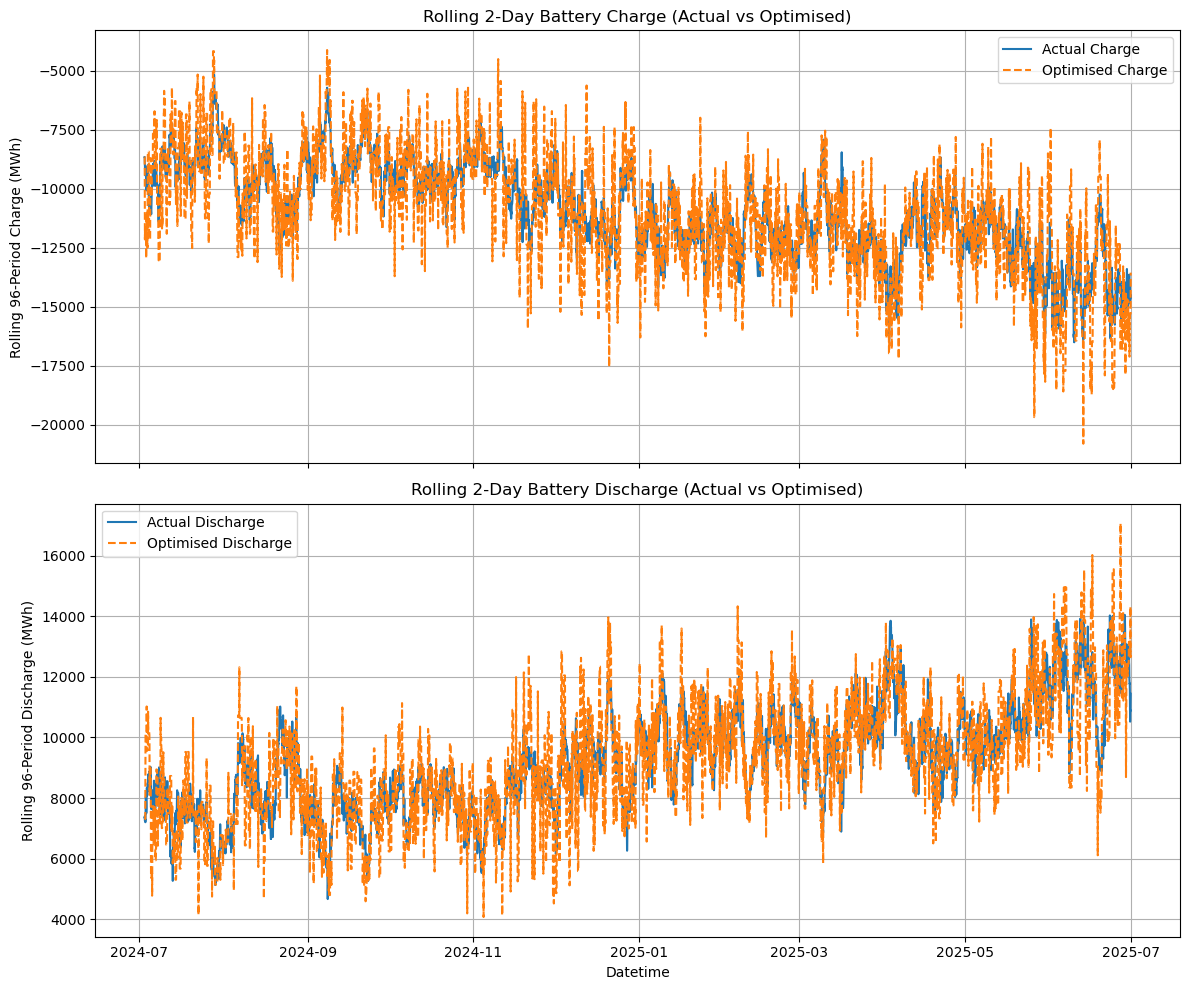

In [12]:
import pandas as pd
import matplotlib.pyplot as plt

# === Load data ===
file_path = r"C:\Users\spice\Dropbox\Documents\Imperial 2024.2025\MECH70038 - Research Projects\_My Thesis\Data\Battery Emissions Optimisation Sheet_optimised_LP.csv"
df = pd.read_csv(file_path)

# === Parse datetime if needed ===
if not pd.api.types.is_datetime64_any_dtype(df['datetime']):
    df['datetime'] = pd.to_datetime(df['datetime'], dayfirst=True)

# === Rolling sums of charge and discharge ===
df['RollingCharge_actual'] = df['BatteryChargeMWh'].rolling(window=96, min_periods=96).sum()
df['RollingCharge_optimised'] = df['OptimisedChargeMWh'].rolling(window=96, min_periods=96).sum()

df['RollingDischarge_actual'] = df['BatteryDischargeMWh'].rolling(window=96, min_periods=96).sum()
df['RollingDischarge_optimised'] = df['OptimisedDischargeMWh'].rolling(window=96, min_periods=96).sum()

# === Plot ===
fig, axs = plt.subplots(2, 1, figsize=(12, 10), sharex=True)

# --- Subplot 1: Charge ---
axs[0].plot(df['datetime'], df['RollingCharge_actual'], label='Actual Charge')
axs[0].plot(df['datetime'], df['RollingCharge_optimised'], label='Optimised Charge', linestyle='--')
axs[0].set_ylabel('Rolling 96-Period Charge (MWh)')
axs[0].set_title('Rolling 2-Day Battery Charge (Actual vs Optimised)')
axs[0].legend()
axs[0].grid(True)

# --- Subplot 2: Discharge ---
axs[1].plot(df['datetime'], df['RollingDischarge_actual'], label='Actual Discharge')
axs[1].plot(df['datetime'], df['RollingDischarge_optimised'], label='Optimised Discharge', linestyle='--')
axs[1].set_ylabel('Rolling 96-Period Discharge (MWh)')
axs[1].set_title('Rolling 2-Day Battery Discharge (Actual vs Optimised)')
axs[1].legend()
axs[1].grid(True)

plt.xlabel('Datetime')
plt.tight_layout()
plt.show()


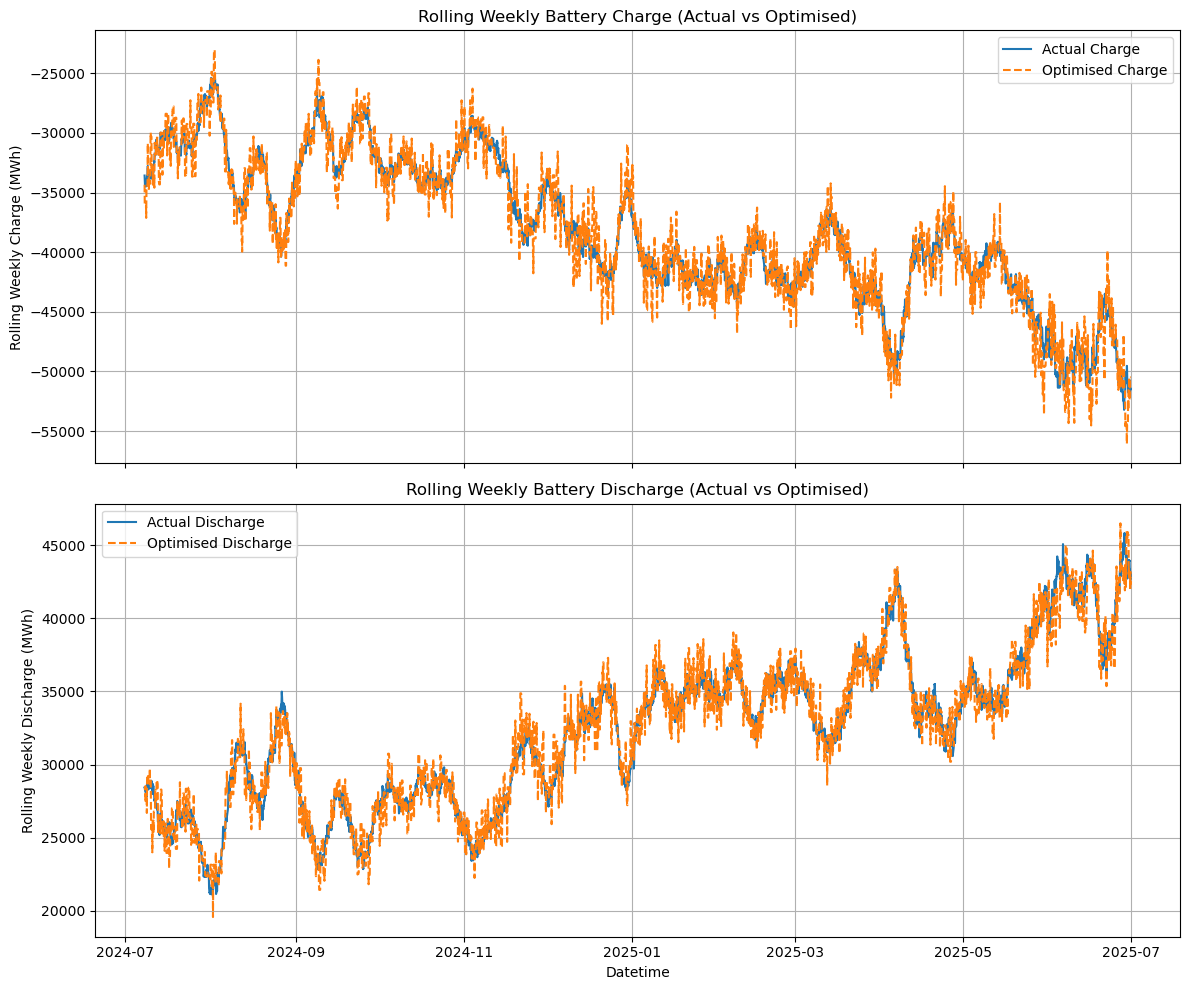

In [11]:
import pandas as pd
import matplotlib.pyplot as plt

# === Load data ===
file_path = r"C:\Users\spice\Dropbox\Documents\Imperial 2024.2025\MECH70038 - Research Projects\_My Thesis\Data\Battery Emissions Optimisation Sheet_optimised_LP.csv"
df = pd.read_csv(file_path)

# === Parse datetime if needed ===
if not pd.api.types.is_datetime64_any_dtype(df['datetime']):
    df['datetime'] = pd.to_datetime(df['datetime'], dayfirst=True)

# === Rolling sums of charge and discharge ===
df['RollingCharge_actual'] = df['BatteryChargeMWh'].rolling(window=336, min_periods=336).sum()
df['RollingCharge_optimised'] = df['OptimisedChargeMWh'].rolling(window=336, min_periods=336).sum()

df['RollingDischarge_actual'] = df['BatteryDischargeMWh'].rolling(window=336, min_periods=336).sum()
df['RollingDischarge_optimised'] = df['OptimisedDischargeMWh'].rolling(window=336, min_periods=336).sum()

# === Plot ===
fig, axs = plt.subplots(2, 1, figsize=(12, 10), sharex=True)

# --- Subplot 1: Charge ---
axs[0].plot(df['datetime'], df['RollingCharge_actual'], label='Actual Charge')
axs[0].plot(df['datetime'], df['RollingCharge_optimised'], label='Optimised Charge', linestyle='--')
axs[0].set_ylabel('Rolling Weekly Charge (MWh)')
axs[0].set_title('Rolling Weekly Battery Charge (Actual vs Optimised)')
axs[0].legend()
axs[0].grid(True)

# --- Subplot 2: Discharge ---
axs[1].plot(df['datetime'], df['RollingDischarge_actual'], label='Actual Discharge')
axs[1].plot(df['datetime'], df['RollingDischarge_optimised'], label='Optimised Discharge', linestyle='--')
axs[1].set_ylabel('Rolling Weekly Discharge (MWh)')
axs[1].set_title('Rolling Weekly Battery Discharge (Actual vs Optimised)')
axs[1].legend()
axs[1].grid(True)

plt.xlabel('Datetime')
plt.tight_layout()
plt.show()


In [ ]:
#This is the old version with the looser constrains of max and min SOC over the entire range, rather than just over a shorter period

# LP version – performance-optimised with precomputed shift mappings
# for full data took 6 mins

import pandas as pd
import numpy as np
from pyomo.environ import *
from pyomo.opt import SolverFactory
from collections import defaultdict

# === CONFIGURATION ===
data_path = r"C:\Users\spice\Dropbox\Documents\Imperial 2024.2025\MECH70038 - Research Projects\_My Thesis\Data\Battery Emissions Optimisation Sheet.csv"
mode = "independent"  # Options: "together" or "independent"
shift_window = 24  # Number of half-hour periods before/after allowed to shift

# === LOAD & PREPROCESS DATA ===
df = pd.read_csv(data_path)
df['SettlementDate'] = df['SettlementDate'].astype(str)
df['SettlementPeriod'] = df['SettlementPeriod'].fillna(0).astype(int)
df['datetime'] = pd.to_datetime(df['SettlementDate'], dayfirst=True, errors='coerce') + pd.to_timedelta((df['SettlementPeriod'] - 1) * 30, unit='m')
df = df.dropna(subset=['datetime']).sort_values('datetime').reset_index(drop=True)

T = len(df)
charge = -df['BatteryChargeMWh'].fillna(0).to_numpy()  # ensure positive values
discharge = df['BatteryDischargeMWh'].fillna(0).to_numpy()
price = df['EmissionFactor'].fillna(0).to_numpy()

# Efficiency and SoC bounds
total_charge = charge.sum()
total_discharge = discharge.sum()
efficiency = total_discharge / total_charge if total_charge > 0 else 1.0

soc_trace = efficiency * np.cumsum(charge) - np.cumsum(discharge)
soc_min = soc_trace.min()
soc_max = soc_trace.max()

max_charge_power = charge.max()
max_discharge_power = discharge.max()

# === BUILD MODEL ===
model = ConcreteModel()

# Index sets
model.T = RangeSet(0, T - 1)
model.S = RangeSet(0, T - 1)

# Shiftable pairs and precomputed fast lookup
valid_shifts = {(t, s) for t in range(T) for s in range(T) if abs(s - t) <= shift_window}
model.shift_pairs = Set(dimen=2, initialize=valid_shifts)

shift_targets = defaultdict(list)  # valid s values per t
shift_sources = defaultdict(list)  # valid t values per s
for t, s in valid_shifts:
    shift_targets[t].append(s)
    shift_sources[s].append(t)

# Variables (LP relaxation)
model.x_charge = Var(model.shift_pairs, domain=UnitInterval)
model.x_discharge = Var(model.shift_pairs, domain=UnitInterval)

# Shifted energy expressions
def shifted_energy_rule(m, s):
    return sum(charge[t] * m.x_charge[t, s] for t in shift_sources[s])
model.charge_shifted = Expression(model.S, rule=shifted_energy_rule)

def shifted_discharge_rule(m, s):
    return sum(discharge[t] * m.x_discharge[t, s] for t in shift_sources[s])
model.discharge_shifted = Expression(model.S, rule=shifted_discharge_rule)

# Objective: maximise price-weighted net export
model.obj = Objective(
    expr=sum(price[s] * (model.discharge_shifted[s] - model.charge_shifted[s]) for s in model.S),
    sense=maximize
)

# Assignment constraints
if mode == "independent":
    model.charge_assignment = ConstraintList()
    model.discharge_assignment = ConstraintList()
    for t in range(T):
        model.charge_assignment.add(sum(model.x_charge[t, s] for s in shift_targets[t]) == 1.0)
        model.discharge_assignment.add(sum(model.x_discharge[t, s] for s in shift_targets[t]) == 1.0)

elif mode == "together":
    model.shared_assignment = ConstraintList()
    for t in range(T):
        for s in shift_targets[t]:
            model.shared_assignment.add(model.x_charge[t, s] == model.x_discharge[t, s])
        model.shared_assignment.add(sum(model.x_charge[t, s] for s in shift_targets[t]) == 1.0)

# Power limits per half-hour
model.charge_power_limit = ConstraintList()
model.discharge_power_limit = ConstraintList()
for s in range(T):
    model.charge_power_limit.add(model.charge_shifted[s] <= max_charge_power)
    model.discharge_power_limit.add(model.discharge_shifted[s] <= max_discharge_power)

# SoC tracking
model.SoC = Var(model.S, domain=Reals)
model.soc_bounds = ConstraintList()
model.soc_def = ConstraintList()
for s in range(T):
    if s == 0:
        model.soc_def.add(model.SoC[s] == efficiency * model.charge_shifted[s] - model.discharge_shifted[s])
    else:
        model.soc_def.add(model.SoC[s] == model.SoC[s - 1] + efficiency * model.charge_shifted[s] - model.discharge_shifted[s])
    model.soc_bounds.add(model.SoC[s] >= soc_min)
    model.soc_bounds.add(model.SoC[s] <= soc_max)

# === SOLVE ===
opt = SolverFactory('cbc')
results = opt.solve(model, tee=True)

if (results.solver.status != SolverStatus.ok) or (results.solver.termination_condition != TerminationCondition.optimal):
    raise RuntimeError("Solver did not find optimal solution.")

# === POSTPROCESS ===
new_charge = np.zeros(T)
new_discharge = np.zeros(T)
for s in range(T):
    new_charge[s] = value(model.charge_shifted[s])
    new_discharge[s] = value(model.discharge_shifted[s])

df['OptimisedChargeMWh'] = -new_charge
df['OptimisedDischargeMWh'] = new_discharge

df.to_csv(data_path.replace('.csv', '_optimised_LP.csv'), index=False)
print("LP Relaxation Optimisation complete. Output saved.")


In [ ]:
#LP version - quicker to run-there is still an issue here - very slow

#import pandas as pd
#import numpy as np
#from pyomo.environ import *
#from pyomo.opt import SolverFactory

# === CONFIGURATION ===
#data_path = r"C:\Users\spice\Dropbox\Documents\Imperial 2024.2025\MECH70038 - Research Projects\_My Thesis\Data\Battery Emissions Optimisation Sheet.csv"
#mode = "independent"  # Options: "together" or "independent"
#shift_window = 24  # Number of half-hour periods before/after allowed to shift (0.5 day)

# === LOAD & PREPROCESS DATA ===
df = pd.read_csv(data_path)
df['SettlementDate'] = df['SettlementDate'].astype(str)
df['SettlementPeriod'] = df['SettlementPeriod'].fillna(0).astype(int)
df['datetime'] = pd.to_datetime(df['SettlementDate'], dayfirst=True, errors='coerce') + pd.to_timedelta((df['SettlementPeriod'] - 1) * 30, unit='m')
df = df.dropna(subset=['datetime']).sort_values('datetime').reset_index(drop=True)

T = len(df)
time_index = list(range(T))

charge = -df['BatteryChargeMWh'].fillna(0).to_numpy()  # positive values
discharge = df['BatteryDischargeMWh'].fillna(0).to_numpy()  # positive values
price = df['EmissionFactor'].fillna(0).to_numpy()

# Efficiency and SoC bounds
total_charge = charge.sum()
total_discharge = discharge.sum()
efficiency = total_discharge / total_charge if total_charge > 0 else 1.0

soc_trace = efficiency * np.cumsum(charge) - np.cumsum(discharge)
soc_min = soc_trace.min()
soc_max = soc_trace.max()

# Power limits
max_charge_power = charge.max()
max_discharge_power = discharge.max()

# === BUILD MODEL ===
model = ConcreteModel()

# Sets
model.T = RangeSet(0, T - 1)
model.S = RangeSet(0, T - 1)

# Shift availability: map each t to valid shiftable s
valid_shifts = {(t, s) for t in model.T for s in model.S if abs(s - t) <= shift_window}
model.shift_pairs = Set(dimen=2, initialize=valid_shifts)

# LP RELAXATION VARIABLES
model.x_charge = Var(model.shift_pairs, domain=UnitInterval)
model.x_discharge = Var(model.shift_pairs, domain=UnitInterval)

# Expression: new charge/discharge series
def shifted_energy_rule(m, s):
    return sum(charge[t] * m.x_charge[t, s] for t in model.T if (t, s) in model.shift_pairs)
model.charge_shifted = Expression(model.S, rule=shifted_energy_rule)

def shifted_discharge_rule(m, s):
    return sum(discharge[t] * m.x_discharge[t, s] for t in model.T if (t, s) in model.shift_pairs)
model.discharge_shifted = Expression(model.S, rule=shifted_discharge_rule)

# Objective: maximize revenue
model.obj = Objective(
    expr=sum(price[s] * (model.discharge_shifted[s] - model.charge_shifted[s]) for s in model.S),
    sense=maximize
)

# === CONSTRAINTS ===

# Each original charge/discharge must be reassigned entirely (sum to 1.0)
if mode == "independent":
    model.charge_assignment = ConstraintList()
    model.discharge_assignment = ConstraintList()
    for t in model.T:
        model.charge_assignment.add(sum(model.x_charge[t, s] for s in model.S if (t, s) in model.shift_pairs) == 1.0)
        model.discharge_assignment.add(sum(model.x_discharge[t, s] for s in model.S if (t, s) in model.shift_pairs) == 1.0)

elif mode == "together":
    model.shared_assignment = ConstraintList()
    for t in model.T:
        for s in model.S:
            if (t, s) in model.shift_pairs:
                model.shared_assignment.add(model.x_charge[t, s] == model.x_discharge[t, s])
        model.shared_assignment.add(
            sum(model.x_charge[t, s] for s in model.S if (t, s) in model.shift_pairs) == 1.0
        )

# Power limit per half-hour
model.charge_power_limit = ConstraintList()
model.discharge_power_limit = ConstraintList()
for s in model.S:
    model.charge_power_limit.add(model.charge_shifted[s] <= max_charge_power)
    model.discharge_power_limit.add(model.discharge_shifted[s] <= max_discharge_power)

# SoC constraints
model.SoC = Var(model.S, domain=Reals)

model.soc_bounds = ConstraintList()
model.soc_def = ConstraintList()
for s in model.S:
    if s == 0:
        model.soc_def.add(model.SoC[s] == efficiency * model.charge_shifted[s] - model.discharge_shifted[s])
    else:
        model.soc_def.add(model.SoC[s] == model.SoC[s - 1] + efficiency * model.charge_shifted[s] - model.discharge_shifted[s])
    model.soc_bounds.add(model.SoC[s] >= soc_min)
    model.soc_bounds.add(model.SoC[s] <= soc_max)

# === SOLVE ===
opt = SolverFactory('cbc')
results = opt.solve(model, tee=True)

# === POSTPROCESS ===
new_charge = np.zeros(T)
new_discharge = np.zeros(T)
for s in range(T):
    new_charge[s] = value(model.charge_shifted[s])
    new_discharge[s] = value(model.discharge_shifted[s])

df['OptimisedChargeMWh'] = -new_charge
df['OptimisedDischargeMWh'] = new_discharge

df.to_csv(data_path.replace('.csv', '_optimised_LP.csv'), index=False)
print("LP Relaxation Optimisation complete. Output saved.")


KeyboardInterrupt: 